<a href="https://colab.research.google.com/github/RakeshKulungRai/Learning_Tensorflow/blob/main/04_Transfer__Learning_in_tensorflow_part1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfe learning witht tesnsorflow part 1: Feature Extraction

Transfer Learning is leveraging a working model's existing architecture and learnde patterns for our own problem.

Therer are two main advandage:
1. Can leverage an existing nn architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on simmilar data to our own, then we can adapt those patterns to our own data


In [ ]:
!nvidia-smi

Wed Feb 22 08:26:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data


In [ ]:
# get 10% of 10 food classes from food101
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-02-22 08:26:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.3MB/s    in 4.6s    

2023-02-22 08:26:47 (34.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent/test.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream.
There are 

## Creating data loaders (preparing the data)
We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Trianing images")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size =  IMAGE_SHAPE,
                                               batch_size =BATCH_SIZE,
                                               class_mode ="categorical")
print("Testing test images")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size= IMAGE_SHAPE,
                                             batch_size= BATCH_SIZE,
                                             class_mode="categorical"
                                             )


Trianing images
Found 750 images belonging to 10 classes.
Testing test images
Found 2500 images belonging to 10 classes.


## Setting up callbacks ( things to run whilst our model trains)

Callbacks are extra funtionality you can add to your models to be performed during or agter training. Some of the modst popular callbacks:
* Tracking experiments with the TensorBoard callback
* Model checkpointing
* Early stopping


In [ ]:
# Create TensorBoard callback (funtionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name +"/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to : {log_dir}")
  return tensorboard_callback

## Create Models using Tensorflow Hub
Tensorflow hub is the repository of the trained machine learning model

We can access pretrained from https://tfhub.dev

Broising the TesnfoFlow Hub page and sorting for image classification we found followin feature vector model link 
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
#Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [ ]:
IMAGE_SHAPE +(3,)

(224, 224, 3)

In [ ]:
def create_model(model_url, num_classes =10):
  """
  Take a tensorflow hub url and creates a keras sequential model with it.

  args :
  model_url (str): Tensorflow hub feature extration URL
  num_classes(int) : Number of output neuraons in the output layer,
   should be equal to number of target class, defalut 10,
   returns 
      an uncompilf Keras Sequential model with model_url as feature extrator
      layer and Dense output layer with num_classes output neurons.
    
  """
  feature_extractor_layer = hub.KerasLayer(model_url,
                                          trainable=False,
                                          name ="feature_extraction_layer",
                                          input_shape=IMAGE_SHAPE +(3,)
                                          )
  # Create our model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name ="output_layer")
  ])
  return model

### Creating and Testing ResNet Tensorflow Hub Feature Extraction model

In [ ]:
# Create Resnet Model

resnet_model = create_model(resnet_url, num_classes= train_data.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer= tf.keras.optimizers.Adam(),
                     metrics =["accuracy"])

In [ ]:
# Lets's fit our ResNet model to the data 
resnet_history = resnet_model.fit(train_data,
                                 epochs =5,
                                 steps_per_epoch = len(train_data),
                                 validation_data = test_data,
                                 validation_steps= len(test_data),
                                 callbacks =[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50v2/20230222-092107
Epoch 1/5
24/24 [==============================] - 37s 1s/step - loss: 1.9698 - accuracy: 0.3427 - val_loss: 1.3065 - val_accuracy: 0.5776
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.9450 - accuracy: 0.7080 - val_loss: 0.9006 - val_accuracy: 0.7124
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6378 - accuracy: 0.8240 - val_loss: 0.7901 - val_accuracy: 0.7452
Epoch 4/5
24/24 [==============================] - 17s 728ms/step - loss: 0.4913 - accuracy: 0.8640 - val_loss: 0.7264 - val_accuracy: 0.7588
Epoch 5/5
24/24 [==============================] - 17s 727ms/step - loss: 0.3884 - accuracy: 0.9133 - val_loss: 0.6887 - val_accuracy: 0.7700


Wow 
Transfer learnninig feature extractor model out performed all of the previous models we built by hand a nd in a quicker training time and only 10% of the training examples

In [ ]:
# Let's creat a funciton of loss curve
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history['val_loss']

  accuracy = history.history["accuracy"]
  val_accuracy = history.history ["val_accuracy"]
  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs, val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend()

  #Plot accuarcy
  plt.figure()
  plt.plot(epochs,accuracy,label="training accuracy")
  plt.plot(epochs, val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend()

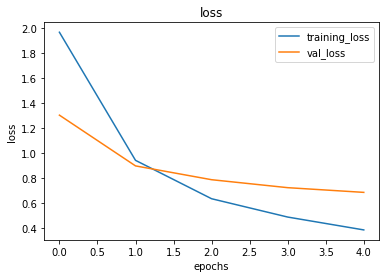

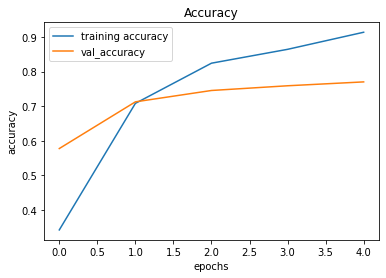

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow Hub feature extraction


In [ ]:
efficientnet_model = create_model(efficientnet_url, num_classes = train_data.num_classes)


In [ ]:
efficientnet_model.compile(loss ="categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics =["accuracy"])

In [ ]:
history_efficientnet = efficientnet_model.fit(train_data,
                                        epochs =5,
                                        steps_per_epoch= len(train_data),
                                        validation_data= test_data,
                                        validation_steps = len(test_data),
                                        callbacks =[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                experiment_name ="efficientnetb0")])

Saving TensorBoard log files to : tensorflow_hub/efficientnetb0/20230222-093836
Epoch 1/5
24/24 [==============================] - 29s 791ms/step - loss: 1.8488 - accuracy: 0.4547 - val_loss: 1.3002 - val_accuracy: 0.7432
Epoch 2/5
24/24 [==============================] - 16s 676ms/step - loss: 1.0623 - accuracy: 0.7853 - val_loss: 0.8651 - val_accuracy: 0.8268
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.7530 - accuracy: 0.8373 - val_loss: 0.6964 - val_accuracy: 0.8452
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.6044 - accuracy: 0.8747 - val_loss: 0.6096 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 17s 729ms/step - loss: 0.5112 - accuracy: 0.8867 - val_loss: 0.5563 - val_accuracy: 0.8608


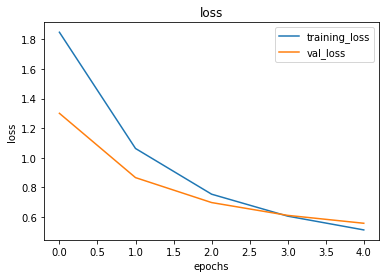

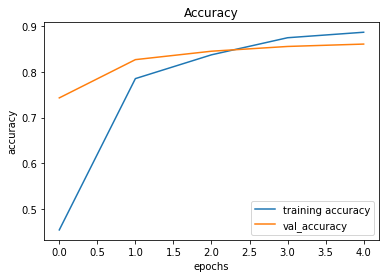

In [ ]:
plot_loss_curves(history_efficientnet)

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


## Different types of transfer learning

* "As is " trannsfer learning - using an existing model with no changes what so ever (eg.)
* "Feature extraction"
* "Fine-tuning " - use perlearned patterns of an existing model and "fine-tune" many or all of undelying layers(including new output layers)

In [ ]:
len(efficientnet_model.layers[0].weights)

309

## Comparing our models using TensorBoard

when you upload things to TensorBoard.dev your experiments are public. So if you/re running private experiments (things don/t want other to see)

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different tf hub feature extractionmodel architectures using 10% of the training dat"\
  --one_shot


2023-02-22 10:25:49.113037: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-22 10:25:49.113140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-22 10:25:49.113159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoar

In [ ]:
# Check out what TensorBoard experiments you have 
! tensorboard dev list

2023-02-22 10:33:10.642468: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-22 10:33:10.642568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-22 10:33:10.642587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
https://tensorboard.dev/experiment/MTpOqULIQZ6zQaconBFpJA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different tf hub fea

In [ ]:
# Delete an experiment
# !tensoboard dev delete --experiment_id MTpOqULIQZ6zQaconBFpJA